### Proyecto Individual Henry  
**2_Transform**  
Transformacion y limpieza de datos  
**Autor: Bioing. Urteaga Facundo Nahuel**  

**Resumen:** Se realiza el desanidado de algunas columnas específicas que contenían los datos anidados (items y reviews de cada usuario), la normalización de los tipos de datos de cada columna y limpieza en general. Este script comprende las siguientes etapas:

1.  **Carga de librerías**
2.  **Carga de datos (archivos .csv generados con el primer script)**
3.  **Desanidado de df_items**
4.  **Transformación y limpieza del df_items desanidado**
5.  **Desanidado de df_reviews**
6.  **Transformación y limpieza del df_reviews desanidado**
7.  **Transformación y limpieza de df_games**
8.  **Creación de df_games_genres, df_games_tags, df_games_specs con generos como variables dummies**
9.  **Creación de df_games_tec con especificaciones técnicas de cada item**
10. **Guardado de dataframes en formato parquet**

In [1]:
# 1. Carga de librerías

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline
import ast
import time
import re

In [2]:
# 2. Carga de datos

df_reviews = pd.read_csv("users_reviews_extraido", low_memory = False) 
df_items = pd.read_csv("users_items_extraido", low_memory = False)
df_games = pd.read_csv("steam_games_extraido", low_memory = False)


In [3]:
# 3. Desanidado de df_items

# Se crea un nuevo dataframe que contenga cada item de cada usuario con la cantidad de tiempo jugado
# print(df_items.iloc[1,4]) <- Este dato se va a desanidar

nombres_columnas = ['user_id', 'item_id', 'playtime_forever','playtime_2weeks']
lst = []

for line in range(0,len(df_items)):
    
    dic_items = ast.literal_eval(df_items["items"][line])
    for items in range(0,df_items["items_count"][line]):
        fila = [df_items["user_id"][line], dic_items[items]["item_id"], dic_items[items]["playtime_forever"], dic_items[items]["playtime_2weeks"]]
        lst.append(fila)

df_des_items = pd.DataFrame(lst, columns= nombres_columnas)


Transformación y limpieza de df_des_items

In [4]:
# 4. Transformación y limpieza de df_des_items

# 4.1. Tratamiento de filas duplicadas

# Encuentra las filas duplicadas
filas_duplicadas = df_des_items[df_des_items.duplicated()]

# Selecciona una fila específica de las filas duplicadas (por ejemplo, la primera fila duplicada)
fila_especifica = filas_duplicadas.iloc[0]

# Encuentra la posición de la fila específica original
posicion_original = df_des_items[df_des_items.eq(fila_especifica).all(1)].index[0]

# Imprime la posición de la fila y su duplicada
print("Posición de la fila original:", posicion_original)
print("Posición de la fila duplicada:", fila_especifica.name)

Posición de la fila original: 164185
Posición de la fila duplicada: 164294


In [5]:
df_des_items.iloc[164185]

user_id             Nikiad
item_id                 20
playtime_forever         5
playtime_2weeks          0
Name: 164185, dtype: object

In [6]:
df_des_items.iloc[164294]

user_id             Nikiad
item_id                 20
playtime_forever         5
playtime_2weeks          0
Name: 164294, dtype: object

In [7]:
# Eliminamos muestras duplicadas

df_des_items = df_des_items.drop_duplicates()

In [8]:
# 4.2. Tratamiento de valores nulos

# Exploro valores nulos por columna
# Calcular la cantidad de valores nulos por columna
valores_nulos_por_columna = df_des_items.isnull().sum()

# Imprimir la cantidad de valores nulos por columna
print(valores_nulos_por_columna)

user_id             0
item_id             0
playtime_forever    0
playtime_2weeks     0
dtype: int64


In [9]:
# 4.3. Tratamiento de valores nan

# Exploro valores nan por columna
# Calcular la cantidad de valores nulos y NaN por columna
valores_nulos_nan_por_columna = df_des_items.isna().sum()

# Imprimir la cantidad de valores nulos y NaN por columna
print(valores_nulos_nan_por_columna)

user_id             0
item_id             0
playtime_forever    0
playtime_2weeks     0
dtype: int64


In [10]:
# 4.4. Control de tipo de dato por columna

df_des_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5094105 entries, 0 to 5153208
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   item_id           object
 2   playtime_forever  int64 
 3   playtime_2weeks   int64 
dtypes: int64(2), object(2)
memory usage: 194.3+ MB


In [11]:
df_des_items['user_id'] = df_des_items['user_id'].astype(str)
df_des_items['item_id'] = df_des_items['item_id'].astype(int)

<Axes: xlabel='playtime_forever', ylabel='Density'>

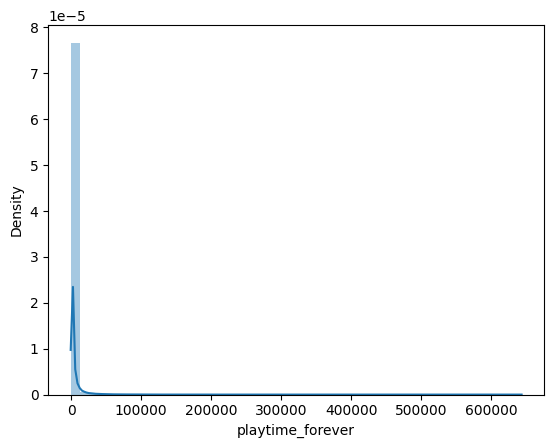

In [12]:
# 4.5. Detección de valores atípicos

sns.distplot(df_des_items['playtime_forever'])

<Axes: xlabel='playtime_2weeks', ylabel='Density'>

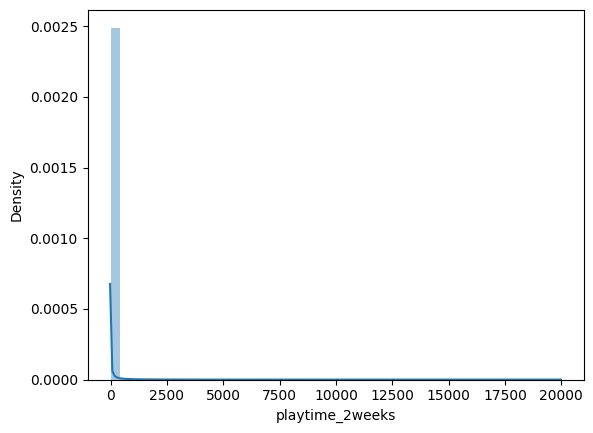

In [13]:
sns.distplot(df_des_items['playtime_2weeks'])

In [14]:
# Hago lo mismo, pero no como minutos aislados sino acumulador por user_id

df_time_forever_user = df_des_items.groupby('user_id')['playtime_forever'].sum().reset_index()
df_time_2week_user = df_des_items.groupby('user_id')['playtime_2weeks'].sum().reset_index()


In [15]:
df_time_2week_user['playtime_2weeks'].nlargest(10)

52202    223199
42043    157009
49877    123358
53421    101801
3210     101337
16504     73935
61455     64766
48314     54385
55541     45871
60409     37493
Name: playtime_2weeks, dtype: int64

<Axes: xlabel='playtime_forever', ylabel='Density'>

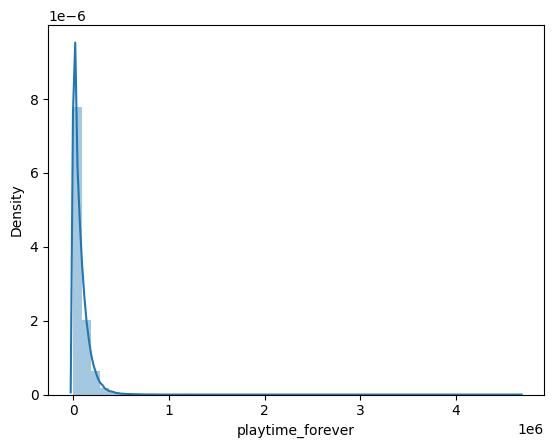

In [16]:
sns.distplot(df_time_forever_user['playtime_forever'])

<Axes: xlabel='playtime_2weeks', ylabel='Density'>

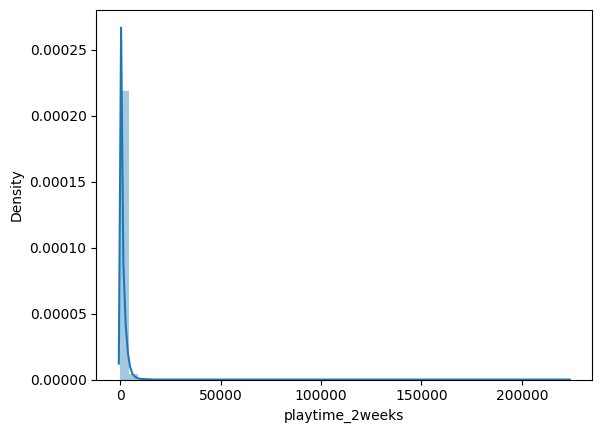

In [17]:
sns.distplot(df_time_2week_user['playtime_2weeks'])

In [18]:
# 5. Desanidado de df_reviews

# Creo el dataframe vacío que quiero obtener

# Nombres de las columnas
nombres_columnas = ['user_id', 'item_id', 'funny','helpful','recommend','review']  # Puedes agregar más nombres si lo necesitas

# Crear DataFrame vacío con los nombres de las columnas
#df_des_reviews = pd.DataFrame(columns=nombres_columnas)

lst = []
aux_cuenta = 0
for line in range(0,len(df_reviews)):
    
    dic_reviews = ast.literal_eval(df_reviews["reviews"][line])
    aux_cuenta = aux_cuenta + len(dic_reviews)
    for review in range(0,len(dic_reviews)):
        
        fila = [df_reviews["user_id"][line], dic_reviews[review]["item_id"], dic_reviews[review]["funny"], dic_reviews[review]["helpful"], 
                dic_reviews[review]["recommend"],dic_reviews[review]['review']]
        lst.append(fila)
        #print(fila)

df_des_reviews = pd.DataFrame(lst, columns= nombres_columnas)

# Imprimir la lista de diccionarios
#print(lista_diccionarios[1]["item_id"])

In [19]:
print(df_des_reviews.isna().sum()) # No hay nans

user_id      0
item_id      0
funny        0
helpful      0
recommend    0
review       0
dtype: int64


In [20]:
# 6. Transformación y limpieza de df_des_reviews

# Contar valores vacíos en cada columna
valores_vacios_por_columna = (df_des_reviews == "").sum()

# Sumar el total de valores vacíos en todo el DataFrame
print(valores_vacios_por_columna) # Valores vacíos en funny y en review

user_id          0
item_id          0
funny        51154
helpful          0
recommend        0
review          31
dtype: int64


In [21]:
df_des_reviews.columns

Index(['user_id', 'item_id', 'funny', 'helpful', 'recommend', 'review'], dtype='object')

In [22]:
#print(df_des_reviews["helpful"].value_counts())
posiciones = []

for line in range(0,len(df_des_reviews)):
    cadena = df_des_reviews["helpful"][line]
    
    if cadena.find(',') > 0:
        cadena = cadena.replace(',', '')  # Eliminar la coma
    
    pos_of = cadena.find("of")
    pos_people = cadena.find("people")
    pos_porc_1 = cadena.find("(")
    pos_porc_2 = cadena.find(")")

    if pos_of > 0:
        df_des_reviews.loc[line, "op_pos"] = int(cadena[:(pos_of-1)])
        df_des_reviews.loc[line, "op_tot"] = int(cadena[(pos_of+3):(pos_people-1)])
        df_des_reviews.loc[line, "op_porc"] = int(cadena[(pos_porc_1+1):(pos_porc_2-1)])
        
        # Para chequear que los valores esten bien
        chequeo = df_des_reviews.loc[line, "op_pos"]/df_des_reviews.loc[line, "op_tot"]
        porc = df_des_reviews.loc[line, "op_porc"]/100
        if(porc > 0):
            if 0.5>(chequeo/porc) or 1.5<(chequeo/porc):
                print((chequeo/porc))
    else:
        df_des_reviews.loc[line, "op_pos"] = np.nan
        df_des_reviews.loc[line, "op_tot"] = np.nan
        df_des_reviews.loc[line, "op_porc"] = np.nan
    
    

In [23]:
df_des_reviews = df_des_reviews.drop(columns=['funny'])
df_des_reviews = df_des_reviews.drop(columns=['helpful'])

<Axes: xlabel='op_porc', ylabel='Density'>

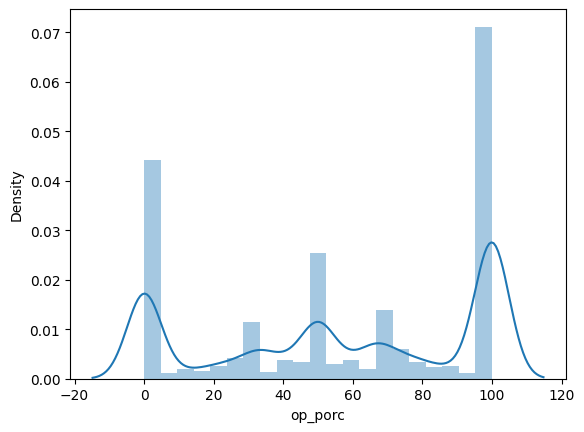

In [24]:
sns.distplot(df_des_reviews['op_porc'])

<Axes: xlabel='op_tot', ylabel='Density'>

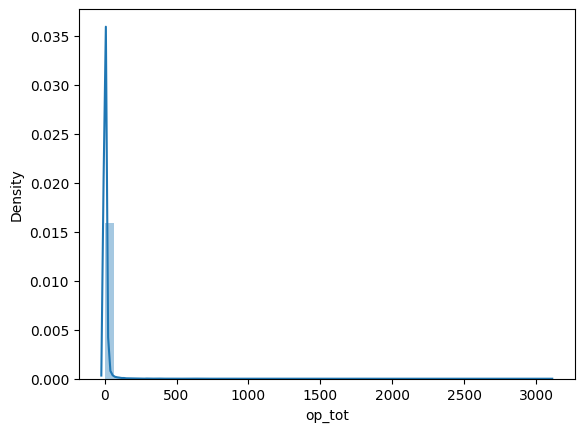

In [25]:
sns.distplot(df_des_reviews['op_tot'])

In [26]:
df_des_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    59305 non-null  object 
 1   item_id    59305 non-null  object 
 2   recommend  59305 non-null  object 
 3   review     59305 non-null  object 
 4   op_pos     29137 non-null  float64
 5   op_tot     29137 non-null  float64
 6   op_porc    29137 non-null  float64
dtypes: float64(3), object(4)
memory usage: 3.2+ MB


In [27]:
# Convierto los tipo de datos de las columnas

df_des_reviews['user_id'] = df_des_reviews['user_id'].astype(str)
df_des_reviews['item_id'] = df_des_reviews['item_id'].astype(int)
df_des_reviews["recommend"] = df_des_reviews["recommend"].map({'True': True, 'False': False})
df_des_reviews['review'] = df_des_reviews['review'].astype(str)

In [28]:
df_des_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    59305 non-null  object 
 1   item_id    59305 non-null  int32  
 2   recommend  59305 non-null  bool   
 3   review     59305 non-null  object 
 4   op_pos     29137 non-null  float64
 5   op_tot     29137 non-null  float64
 6   op_porc    29137 non-null  float64
dtypes: bool(1), float64(3), int32(1), object(2)
memory usage: 2.5+ MB


In [29]:
# 7. Transformación y limpieza de df_games

df_des_games = df_games.dropna(how='all') #120445

In [30]:
# Chequeo elementos vacíos por columna y tipo de dato

df_des_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24064 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  object 
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(1), object(12)
memory usage: 3.4+ MB


In [31]:
# Observamos que ambas columnas tienen el mismo dato

conteo_valores = (df_des_games['app_name'] == df_des_games['title']).value_counts()
print(conteo_valores)


True     29530
False     2605
Name: count, dtype: int64


In [32]:
# Eliminar filas en las que ambas columnas son nulas
df_des_games = df_des_games.dropna(subset=['app_name', 'title'], how='all')


In [33]:
# Si en alguna de las dos columnas falta el dato, se completa con el de la otra columna

# Corregir los valores nulos en las columnas "app_name" y "title"
df_des_games["app_name"].fillna(df_des_games["title"], inplace=True)
df_des_games["title"].fillna(df_des_games["app_name"], inplace=True)

In [34]:
# Filtrar el DataFrame para obtener filas donde las columnas 'app_name' y 'title' no son iguales
filas_no_iguales = df_des_games[df_des_games['app_name'] != df_des_games['title']]

# Mostrar ejemplos de filas donde las columnas no son iguales
print(filas_no_iguales[['app_name', 'title']])

                                             app_name  \
88390                    Sam & Max 101: Culture Shock   
88393                Sam & Max 102: Situation: Comedy   
88419                  Command & Conquer: Red Alert 3   
88492      Heroes of Might & Magic V: Hammers of Fate   
88494   Heroes of Might & Magic V: Tribes of the East   
...                                               ...   
120181                     Sam & Max 105: Reality 2.0   
120182           Sam & Max 104: Abe Lincoln Must Die!   
120183         Sam & Max 106: Bright Side of the Moon   
120208           Making History: The Calm & the Storm   
120362                  Dark Messiah of Might & Magic   

                                                    title  
88390                    Sam &amp; Max 101: Culture Shock  
88393                Sam &amp; Max 102: Situation: Comedy  
88419                  Command &amp; Conquer: Red Alert 3  
88492      Heroes of Might &amp; Magic V: Hammers of Fate  
88494   Heroes 

In [35]:
type(df_des_games["genres"].iloc[1])

str

In [36]:
df_des_games["genres"].info()

<class 'pandas.core.series.Series'>
Index: 32133 entries, 88310 to 120444
Series name: genres
Non-Null Count  Dtype 
--------------  ----- 
28851 non-null  object
dtypes: object(1)
memory usage: 502.1+ KB


In [37]:
# 8. Creación de df_games_genres, df_games_tags, df_games_specs con generos como variables dummies

# Reemplazo nos nan por listas vacías
for fila in range(len(df_des_games)):
    if pd.isna(df_des_games["genres"].iloc[fila]):
        df_des_games["genres"].iloc[fila] = []
    if pd.isna(df_des_games["tags"].iloc[fila]):
        df_des_games["tags"].iloc[fila] = []
    if pd.isna(df_des_games["specs"].iloc[fila]):
        df_des_games["specs"].iloc[fila] = []

In [38]:
# Transformo str en listas de str
for fila in range(len(df_des_games)):
    if df_des_games["genres"].iloc[fila] != []:
        df_des_games["genres"].iloc[fila] = ast.literal_eval(df_des_games["genres"].iloc[fila])
    if df_des_games["tags"].iloc[fila] != []:
        df_des_games["tags"].iloc[fila] = ast.literal_eval(df_des_games["tags"].iloc[fila])
    if df_des_games["specs"].iloc[fila] != []:
        df_des_games["specs"].iloc[fila] = ast.literal_eval(df_des_games["specs"].iloc[fila])

In [39]:
# Primero, convierte las listas en una sola lista plana
lista_de_nombres_genres = [nombre for sublist in df_des_games["genres"] for nombre in sublist]
lista_de_nombres_tags = [nombre for sublist in df_des_games["tags"] for nombre in sublist]
lista_de_nombres_specs = [nombre for sublist in df_des_games["specs"] for nombre in sublist]

# Luego, crea un conjunto (set) para obtener los valores únicos
valores_unicos_genres = set(lista_de_nombres_genres)
valores_unicos_tags = set(lista_de_nombres_tags)
valores_unicos_specs = set(lista_de_nombres_specs)

# Finalmente, cuenta la longitud del conjunto para obtener el número de valores únicos
num_valores_unicos_genres = len(valores_unicos_genres)
num_valores_unicos_tags = len(valores_unicos_tags)
num_valores_unicos_specs = len(valores_unicos_specs)

# Imprime el resultado
#print(valores_unicos)

In [40]:
# Crea un conjunto de todos los géneros únicos
unique_genres = set(g for sublist in df_des_games['genres'] for g in sublist)
# Crea un conjunto de todos los tags únicos
unique_tags = set(g for sublist in df_des_games['tags'] for g in sublist)
# Crea un conjunto de todos los specs únicos
unique_specs = set(g for sublist in df_des_games['specs'] for g in sublist)

# Creo nuevos DF

df_games_genres = df_des_games[["id","genres"]]
df_games_tags = df_des_games[["id","tags"]]
df_games_specs = df_des_games[["id","specs"]]

# Para cada género único, crea una nueva columna en el DataFrame con valores True/False
for genre in unique_genres:
    df_games_genres[genre] = df_des_games['genres'].apply(lambda x: genre in x).astype(int)
# Para cada género único, crea una nueva columna en el DataFrame con valores True/False
for tag in unique_tags:
    df_games_tags[tag] = df_des_games['tags'].apply(lambda x: tag in x).astype(int)
# Para cada género único, crea una nueva columna en el DataFrame con valores True/False
for spec in unique_specs:
    df_games_specs[spec] = df_des_games['specs'].apply(lambda x: spec in x).astype(int)

In [41]:
df_des_games.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'reviews_url', 'specs', 'price', 'early_access', 'id',
       'developer'],
      dtype='object')

In [42]:
# 9. Creación de df_games_tec con especificaciones técnicas de cada item

df_games_tec = df_des_games[['app_name', 'id', 'publisher', 'release_date', 'price', 'developer']]
df_games_tec = df_games_tec.reset_index(drop=True)

In [43]:
df_games_tec['price'] = df_games_tec['price'].replace('', np.nan)

In [44]:
# Imprime las celdas que no contienen un punto "."
print("Celdas que no contienen un punto '.' en la columna 'price':")
non_decimal_prices = df_games_tec[~df_games_tec['price'].str.contains("\.", na=False)]
print(non_decimal_prices["price"].value_counts())

# Luego, reemplaza las celdas que no son numéricas con un valor numérico específico, por ejemplo, 0
df_games_tec.loc[~df_games_tec['price'].str.contains("\.", na=False), 'price'] = '0'

Celdas que no contienen un punto '.' en la columna 'price':
price
Free                             905
Free to Play                     520
Free To Play                     462
Free Mod                           4
Free Demo                          3
Play for Free!                     2
Third-party                        2
Play Now                           2
Install Now                        1
Play WARMACHINE: Tactics Demo      1
Install Theme                      1
Free HITMAN™ Holiday Pack          1
Play the Demo                      1
Free to Try                        1
Free Movie                         1
Free to Use                        1
Name: count, dtype: int64


In [45]:
# Luego, reemplaza las celdas que no son numéricas con un valor numérico específico, por ejemplo, 0
for index, value in df_games_tec['price'].items():
    try:
        if not pd.isnull(value) and not value.replace('.', '', 1).isdigit():
            print(f"Valor no numérico en la fila {index}: {value}")
            # Pintar la celda aquí
            continue
    except AttributeError:
        print(f"Error al convertir a numérico en la fila {index}: {value}")
        # Pintar la celda aquí
        continue

Valor no numérico en la fila 24998: Starting at $499.00
Valor no numérico en la fila 24999: Starting at $449.00


In [46]:
df_games_tec["price"].iloc[24998] = 499.00
df_games_tec["price"].iloc[24999] = 449.00

In [47]:
# Ahora, convierte la columna 'price' a tipo numérico
df_games_tec['price'] = pd.to_numeric(df_games_tec['price'])

In [48]:
# Convierte los valores nulos en la columna 'release_date' en NaN
df_games_tec['release_date'] = df_games_tec['release_date'].replace('', np.nan)
df_games_tec['publisher'] = df_games_tec['publisher'].replace('', np.nan)
df_games_tec['developer'] = df_games_tec['developer'].replace('', np.nan)
df_games_tec.dropna(subset=['id'], inplace=True)

In [49]:
# Todas las celdas que no tengan fechas son cambiadas a nan
df_games_tec.loc[~df_games_tec['release_date'].str.contains("[12]", na=False), 'release_date'] = np.nan

In [50]:
seleccion = df_games_tec[~df_games_tec['release_date'].str.contains("-", na=True)]
print(df_games_tec.loc[seleccion.index, 'release_date'])

43               2017
249          Jun 2009
505          Oct 2010
508          Oct 2010
509          Oct 2010
             ...     
32079         Q1 2018
32080      15.01.2018
32081        Q1, 2018
32095            2016
32121    January 2018
Name: release_date, Length: 185, dtype: object


In [51]:

# Crea una función para extraer el año de la fecha
def extract_year(date_str):
    # Busca "20" o "19" seguido de 4 dígitos consecutivos
    year_match = re.search(r"(20|19)\d{2}", date_str)
    if year_match:
        return year_match.group(0)
    else:
        return None

# Aplica la función a la columna 'release_date'
df_games_tec.loc[seleccion.index, 'release_date'] = df_games_tec['release_date'].apply(lambda x: extract_year(x) if pd.notnull(x) else None)


In [52]:
print(df_games_tec.loc[seleccion.index, 'release_date'])

43       2017
249      2009
505      2010
508      2010
509      2010
         ... 
32079    2018
32080    2018
32081    2018
32095    2016
32121    2018
Name: release_date, Length: 185, dtype: object


In [53]:
seleccion = df_games_tec[~df_games_tec['release_date'].str.contains("[21-]", na=True)]
print(df_games_tec.loc[seleccion.index, 'release_date'])

Series([], Name: release_date, dtype: object)


In [54]:
# Crea una función para extraer el año de la fecha
def extract_year(date_str):
    # Busca "20" o "19" seguido de 4 dígitos consecutivos
    year_match = re.search(r"(20|19)\d{2}", date_str)
    if year_match:
        return year_match.group(0)
    else:
        return None

In [55]:
# Convierte la columna 'release_date' a tipo datetime si aún no lo está
df_games_tec['release_date'] = pd.to_datetime(df_games_tec['release_date'], errors = 'coerce')

In [56]:
# Extraer el año en una nueva columna
df_games_tec['release_year'] = df_games_tec['release_date'].dt.year

# Si la fecha solo tiene el año (por ejemplo, "2010"), la conversión anterior producirá un NaT (Not a Time), así que debemos rellenar esos valores con el año extraído de la misma columna
df_games_tec['release_year'] = df_games_tec['release_year'].fillna(df_games_tec['release_date'].dt.strftime('%Y'))

# Convertir 'año' a tipo entero si es posible
df_games_tec['release_year'] = pd.to_numeric(df_games_tec['release_year'], errors='coerce').astype('Int64')

In [57]:
df_games_tec["release_year"].value_counts()

release_year
2017    9518
2016    6933
2015    4945
2014    2831
2013    1551
2012    1191
2011     589
2010     436
2009     337
2008     213
2007     167
2006     155
2005     102
2018      96
2003      84
2004      79
2001      69
1998      61
1999      55
2002      50
1997      42
2000      40
1996      39
1994      36
1993      34
1995      33
1991      16
1992      15
1990      12
1989      10
1987       9
1988       7
1984       4
1983       4
1985       3
1982       3
1981       3
2019       3
1970       2
1986       1
2021       1
1975       1
1980       1
Name: count, dtype: Int64

In [58]:
df_games_tec.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32132 entries, 0 to 32132
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   app_name      32132 non-null  object        
 1   id            32132 non-null  float64       
 2   publisher     24063 non-null  object        
 3   release_date  29781 non-null  datetime64[ns]
 4   price         32132 non-null  float64       
 5   developer     28835 non-null  object        
 6   release_year  29781 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), float64(2), object(3)
memory usage: 3.0+ MB


In [59]:
# 10. Guardado de dataframes en formato parquet

df_games_tec.rename(columns={'id': 'item_id'}, inplace=True)
df_games_genres.rename(columns={'id': 'item_id'}, inplace=True)
df_games_specs.rename(columns={'id': 'item_id'}, inplace=True)
df_games_tags.rename(columns={'id': 'item_id'}, inplace=True)

In [60]:
df_games_tec = df_games_tec.reset_index(drop=True)
df_games_genres = df_games_genres.reset_index(drop=True) 
df_games_specs = df_games_specs.reset_index(drop=True)
df_games_tags = df_games_tags.reset_index(drop=True)
df_des_reviews = df_des_reviews.reset_index(drop=True) 
df_des_items = df_des_items.reset_index(drop=True)

In [61]:
df_games_tec.to_parquet('df_games_tec.parquet')
df_games_genres.to_parquet('df_games_genres.parquet')
df_games_specs.to_parquet('df_games_specs.parquet')
df_games_tags.to_parquet('df_games_tags.parquet')
df_des_reviews.to_parquet('df_reviews.parquet')
df_des_items.to_parquet('df_items.parquet')